In [2279]:
import numpy as np

# two d=3 qudits

In [2280]:
n_qudits = 2
d = 3

### Generate "unkown" state you want to learn

In [2281]:
def random_complex_vector(n):
    # Generate random real and imaginary parts
    real_part = np.random.uniform(low=-1, high=1, size=n)
    imag_part = np.random.uniform(low=-1, high=1, size=n)
    
    # Combine them to form a complex vector
    vector = real_part + 1j * imag_part
    
    # Normalize the vector to have norm = 1
    norm = np.linalg.norm(vector)
    normalized_vector = vector / norm
    
    return normalized_vector

psi = random_complex_vector(d**n_qudits).reshape(-1, 1)
unkown_dm = psi @ psi.conj().T

### Define measurement bases 

In [2282]:
smallest_bases = False
experimental_bases = True # also the same size as "smallest", rename eventually

zero = np.array([1, 0, 0]).reshape(-1, 1)
one = np.array([0, 1, 0]).reshape(-1, 1)
two = np.array([0, 0, 1]).reshape(-1, 1)

if smallest_bases is True:
    # Used for meeting at 4-18-25
    basis_states = []

    for i in range(d**n_qudits):
        # Direct measurements of "alpha"
        basis_vector = np.zeros(d**n_qudits, dtype=np.complex128).reshape(-1, 1)
        basis_vector[i] = 1
        basis_states.append(basis_vector)

        if i > 0: # add bases for phase measurements
            basis_vector_plus = np.zeros(d**n_qudits, dtype=np.complex128).reshape(-1, 1)
            basis_vector_plus[0] = 1
            basis_vector_plus[i] = 1
            basis_vector_plus *= 1/np.sqrt(2)

            basis_vector_i = basis_vector_plus.copy()
            basis_vector_i[i] *= 1j

            basis_states.append(basis_vector_plus)
            basis_states.append(basis_vector_i)
elif experimental_bases is True: # TODO: check if there is a performance difference as compared to "smallest_bases"
    # Rewrite with more experimentally-realistic basis
    basis_states = []

    for i in range(d**n_qudits):
        # Direct measurements of "alpha"
        basis_vector = np.zeros(d**n_qudits, dtype=np.complex128).reshape(-1, 1)
        basis_vector[i] = 1
        basis_states.append(basis_vector)

    basis_states.append(1/np.sqrt(2) * (np.kron(zero, zero) + np.kron(zero, one)))
    basis_states.append(1/np.sqrt(2) * (np.kron(zero, zero) + 1j * np.kron(zero, one)))

    basis_states.append(1/np.sqrt(2) * (np.kron(zero, zero) + np.kron(zero, two)))
    basis_states.append(1/np.sqrt(2) * (np.kron(zero, zero) + 1j * np.kron(zero, two)))

    basis_states.append(1/np.sqrt(2) * (np.kron(zero, zero) + np.kron(one, zero)))
    basis_states.append(1/np.sqrt(2) * (np.kron(zero, zero) + 1j * np.kron(one, zero)))

    basis_states.append(1/np.sqrt(2) * (np.kron(zero, zero) + np.kron(two, zero)))
    basis_states.append(1/np.sqrt(2) * (np.kron(zero, zero) + 1j * np.kron(two, zero)))

    basis_states.append(1/np.sqrt(2) * (np.kron(zero, one) + np.kron(one, one)))
    basis_states.append(1/np.sqrt(2) * (np.kron(zero, one) + 1j * np.kron(one, one)))

    basis_states.append(1/np.sqrt(2) * (np.kron(zero, one) + np.kron(two, one)))
    basis_states.append(1/np.sqrt(2) * (np.kron(zero, one) + 1j * np.kron(two, one)))

    basis_states.append(1/np.sqrt(2) * (np.kron(zero, two) + np.kron(one, two)))
    basis_states.append(1/np.sqrt(2) * (np.kron(zero, two) + 1j * np.kron(one, two)))
                        
    basis_states.append(1/np.sqrt(2) * (np.kron(zero, two) + np.kron(two, two)))
    basis_states.append(1/np.sqrt(2) * (np.kron(zero, two) + 1j * np.kron(two, two)))

else:
    zero = np.array([1, 0, 0]).reshape(-1, 1)
    one = np.array([0, 1, 0]).reshape(-1, 1)
    two = np.array([0, 0, 1]).reshape(-1, 1) 

    plus_zero_one = 1/np.sqrt(2) * np.array([1, 1, 0]).reshape(-1, 1)
    i_zero_one = 1/np.sqrt(2) * np.array([1, 1j, 0]).reshape(-1, 1)

    plus_zero_two = 1/np.sqrt(2) * np.array([1, 0, 1]).reshape(-1, 1)
    i_zero_two = 1/np.sqrt(2) * np.array([1, 0, 1j]).reshape(-1, 1)

    basis_states = [zero, one, two,
                    plus_zero_one, i_zero_one,
                    plus_zero_two, i_zero_two]

In [2283]:
basis_states[9]

array([[0.70710678],
       [0.70710678],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ]])

### Create measurement projectors

In [2284]:
# 2 qubits
if smallest_bases or experimental_bases is True:
    measurement_operators = [state_vector @ state_vector.conj().T for state_vector in basis_states]
    two_qudit_measurement_operators = measurement_operators
else: 
    measurement_operators = [state_vector @ state_vector.conj().T for state_vector in basis_states]
    two_qudit_measurement_operators = []
    for qubit_1_op in measurement_operators:
        for qubit_2_op in measurement_operators:
            two_qudit_measurement_operators.append(np.kron(qubit_1_op, qubit_2_op))

In [2285]:
len(two_qudit_measurement_operators)

25

### Compute probabilities to use as the data to fit to
Experimentally, you would compute these from measurement counts

In [2286]:
def get_probabilities(dm):
    return [np.trace(dm @ measurement_op).real for measurement_op in two_qudit_measurement_operators]

probabilities = get_probabilities(unkown_dm)

### Create tunable state
Parameterization from: https://research.physics.illinois.edu/QI/Photonics/tomography-files/tomo_chapter_2004.pdf

In [2287]:
def get_parameterized_dm(t):
    """ t is a list of the tunable parameters. Returns a lower triangular matrix with complex elements below the diagonal
    real elements on the diagonal. """
    T = np.zeros((9, 9), dtype=np.complex_)
    index = 0 
    for i, row in enumerate(T):
        for j in range(len(row)):
            if j < i:
                T[i, j] = t[index] + 1j*t[index + 1]
                index += 2
            elif i == j:
                T[i, j] = t[index]
                index += 1
            else:
                continue

    parameterized_rho = (T.conj().T @ T) / np.trace(T.conj().T @ T)
    return parameterized_rho

In [2288]:
dm_parameters = np.random.uniform(low=-1, high=1, size=d**n_qudits**2)

In [2289]:
parameterized_dm = get_parameterized_dm(dm_parameters)

### Test that DM is valid

In [2290]:
# Check that trace is close to one
assert np.allclose(1, np.trace(parameterized_dm))

# Check Hermitian
assert np.allclose(parameterized_dm, parameterized_dm.conj().T)

# Check positive-semi definite <--> eigenvalues >= 0
assert np.all(np.linalg.eigvalsh(parameterized_dm) >= 0)

### Optimize with SciPy

In [2291]:
def get_probabilites_from_parameters(t):
    parameterized_dm = get_parameterized_dm(t)
    probabilities = get_probabilities(parameterized_dm)
    return probabilities

In [2292]:
from scipy.special import kl_div

def kl_divergence(true_probs, t):
    probs = get_probabilites_from_parameters(t)
    return sum(kl_div(true_probs, probs))

kl_divergence_from_parameters = lambda params : kl_divergence(probabilities, params)

In [2293]:
from scipy.optimize import minimize

optimization_result = minimize(kl_divergence_from_parameters, dm_parameters, method="L-BFGS-B")

In [2294]:
found_params = optimization_result.x

found_dm = get_parameterized_dm(found_params)

# Density Matrix Fidelity: "Unknown" DM vs. Reconstructed DM

In [2295]:
dm_fidelity = lambda d1, d2 : np.trace(d1.T.conj() @ d2).real

print("Density matrix fidelity:", dm_fidelity(unkown_dm, found_dm))

Density matrix fidelity: 0.9841512940574496


### Plot Density Matrices

In [2296]:
import matplotlib as mplt
import matplotlib.pyplot as plt
%matplotlib inline

In [2297]:
def bar_plot_3d(top, title=""):
    # set up the figure and axes
    fig = plt.figure(figsize=(8, 3))
    ax = fig.add_subplot(121, projection='3d')

    x_dim = y_dim = len(top)
    
    # fake data
    _x = np.arange(x_dim)
    _y = np.arange(y_dim)
    _xx, _yy = np.meshgrid(_x, _y)
    x, y = _xx.ravel(), _yy.ravel()

    # top = x + y

    bottom = np.zeros_like(top)
    width = depth = 0.5

    ax.bar3d(x, y, bottom.flatten(), width, depth, top.flatten(), shade=True)
    ax.set_title(title)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xlabel("row")
    ax.set_ylabel("column")


    plt.show()

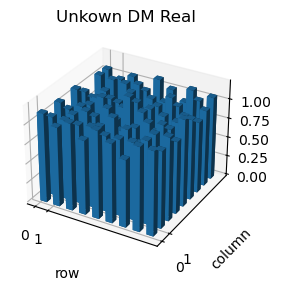

[[1.14010018 1.01629741 1.11760481 0.95196494 1.12693685 1.01551087
  0.86315006 1.07782671 1.07736976]
 [1.01629741 1.02002489 1.00971515 1.0333825  0.97239033 0.9810676
  0.99061315 1.06183431 0.98775721]
 [1.11760481 1.00971515 1.09958882 0.95115364 1.11582409 1.01755617
  0.88369467 1.05378539 1.06959333]
 [0.95196494 1.0333825  0.95115364 1.10023992 0.86538703 0.95010621
  1.06096288 1.0867742  0.92780894]
 [1.12693685 0.97239033 1.11582409 0.86538703 1.21406176 1.06252463
  0.86073867 0.94714139 1.11975476]
 [1.01551087 0.9810676  1.01755617 0.95010621 1.06252463 1.02543672
  0.97737688 0.94824348 1.03286434]
 [0.86315006 0.99061315 0.88369467 1.06096288 0.86073867 0.97737688
  1.13602897 0.94299745 0.91677067]
 [1.07782671 1.06183431 1.05378539 1.0867742  0.94714139 0.94824348
  0.94299745 1.1968999  0.98113272]
 [1.07736976 0.98775721 1.06959333 0.92780894 1.11975476 1.03286434
  0.91677067 0.98113272 1.06761884]]


In [2298]:
bar_plot_3d(unkown_dm.real + 1, title="Unkown DM Real")
print(unkown_dm.real + 1)

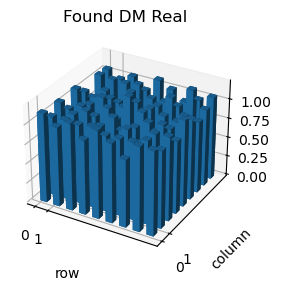

[[1.14000922 1.01615545 1.1169437  0.95221463 1.12705711 1.01534194
  0.86331309 1.07776375 1.07543286]
 [1.01615545 1.02015485 1.00980334 1.03349587 0.97248335 0.98113764
  0.99062911 1.06157637 0.98949678]
 [1.1169437  1.00980334 1.10008145 0.95194101 1.11366693 1.01730696
  0.88441927 1.05597808 1.06901947]
 [0.95221463 1.03349587 0.95194101 1.10007837 0.86707735 0.95037715
  1.06041298 1.08490923 0.93174683]
 [1.12705711 0.97248335 1.11366693 0.86707735 1.21383331 1.06122326
  0.8613236  0.9480453  1.11110279]
 [1.01534194 0.98113764 1.01730696 0.95037715 1.06122326 1.0254146
  0.97767324 0.94999548 1.03154475]
 [0.86331309 0.99062911 0.88441927 1.06041298 0.8613236  0.97767324
  1.13581214 0.94227966 0.91897887]
 [1.07776375 1.06157637 1.05597808 1.08490923 0.9480453  0.94999548
  0.94227966 1.19682145 0.99020592]
 [1.07543286 0.98949678 1.06901947 0.93174683 1.11110279 1.03154475
  0.91897887 0.99020592 1.06779462]]


In [2299]:
bar_plot_3d(found_dm.real + 1, title="Found DM Real")
print(found_dm.real + 1)

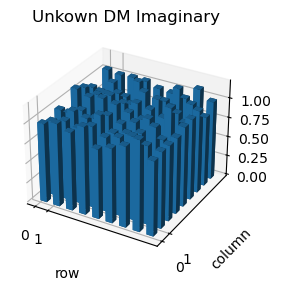

[[1.         1.05039728 0.98897642 1.10833404 0.88219879 0.94235365
  1.01815971 1.14672666 0.94094636]
 [0.94960272 1.         0.95641249 1.02988148 0.94063443 0.98771456
  1.05134056 0.98907217 0.96529879]
 [1.01102358 1.04358751 1.         1.08715967 0.91110154 0.95283016
  1.00447603 1.12929099 0.95651612]
 [0.89166596 0.97011852 0.91284033 1.         0.94223424 1.0077708
  1.09959448 0.88951258 0.96042023]
 [1.11780121 1.05936557 1.08889846 1.05776576 1.         0.96081199
  0.90138519 1.19838021 1.01155008]
 [1.05764635 1.01228544 1.04716984 0.9922292  1.03918801 1.
  0.94570151 1.0482675  1.02529698]
 [0.98184029 0.94865944 0.99552397 0.90040552 1.09861481 1.05429849
  1.         0.84658944 1.047655  ]
 [0.85327334 1.01092783 0.87070901 1.11048742 0.80161979 0.9517325
  1.15341056 1.         0.88616605]
 [1.05905364 1.03470121 1.04348388 1.03957977 0.98844992 0.97470302
  0.952345   1.11383395 1.        ]]


In [2300]:
bar_plot_3d(unkown_dm.imag + 1, title="Unkown DM Imaginary")
print(unkown_dm.imag + 1)

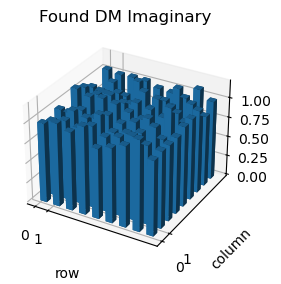

[[1.         1.0503113  0.98931815 1.10817153 0.88455376 0.94249299
  1.01791432 1.14336876 0.94411318]
 [0.9496887  1.         0.95727445 1.02965657 0.94067478 0.98791383
  1.05117601 0.9890894  0.96690718]
 [1.01068185 1.04272555 1.         1.08627287 0.914749   0.95308749
  1.00467315 1.12335209 0.95719623]
 [0.89182847 0.97034343 0.91372713 1.         0.94098541 1.00772983
  1.09946348 0.89122997 0.96106095]
 [1.11544624 1.05932522 1.085251   1.05901459 1.         0.96023094
  0.9034358  1.194242   1.01154716]
 [1.05750701 1.01208617 1.04691251 0.99227017 1.03976906 1.
  0.94576399 1.04734282 1.02476565]
 [0.98208568 0.94882399 0.99532685 0.90053652 1.0965642  1.05423601
  1.         0.85005262 1.04494958]
 [0.85663124 1.0109106  0.87664791 1.10877003 0.805758   0.95265718
  1.14994738 1.         0.89216228]
 [1.05588682 1.03309282 1.04280377 1.03893905 0.98845284 0.97523435
  0.95505042 1.10783772 1.        ]]


In [2301]:
bar_plot_3d(found_dm.imag + 1, title="Found DM Imaginary")
print(found_dm.imag + 1)

## Reconstruct state vector from the density matrix 

In [2302]:
def density_matrix_to_state_vector(rho):
    """Extracts a state vector from a pure-state density matrix."""
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(rho)

    # Find the eigenvector corresponding to eigenvalue ~1
    idx = np.argmax(eigenvalues)  # The largest eigenvalue (should be ~1 for a pure state)
    
    # Extract the corresponding eigenvector
    state_vector = eigenvectors[:, idx]

    # Normalize the state vector
    state_vector = state_vector / np.linalg.norm(state_vector)

    return state_vector

#### original psi

In [2303]:
print("original psi", psi)

prob_0 = np.abs(psi[0])**2
prob_1 = np.abs(psi[1])**2
print("prob_0", prob_0)
print("prob_1", prob_1)

original psi [[-0.0818939 +0.36523084j]
 [ 0.12185554+0.07194527j]
 [-0.09748217+0.30014337j]
 [ 0.31049718-0.06189849j]
 [-0.38129852+0.26205572j]
 [-0.1593465 +0.00673921j]
 [ 0.12733505-0.34614268j]
 [ 0.33701292+0.28865584j]
 [-0.19917405+0.16717815j]]
prob_0 [0.14010018]
prob_1 [0.02002489]


#### original psi from density matrix, testing that it matches psi

In [2304]:
original_psi_from_dm = density_matrix_to_state_vector(unkown_dm)
print("original_psi_from_dm", original_psi_from_dm)

prob_0 = np.abs(original_psi_from_dm[0])**2
prob_1 = np.abs(original_psi_from_dm[1])**2
print("prob_0", prob_0)
print("prob_1", prob_1)

original_psi_from_dm [ 0.37429958+0.j          0.04354107-0.13464423j  0.31419968+0.02945123j
 -0.1283332 -0.28943136j  0.33913169+0.3147244j   0.04143973+0.15401127j
 -0.36561608-0.04851652j  0.20792626-0.39200328j  0.20670543+0.15777104j]
prob_0 0.14010017619747084
prob_1 0.020024894542118116


#### statevector from reconstructed dm

In [2305]:
found_psi_from_dm = density_matrix_to_state_vector(found_dm)
print("found_psi_from_dm", found_psi_from_dm)
prob_0 = np.abs(found_psi_from_dm[0])**2
prob_1 = np.abs(found_psi_from_dm[1])**2
print("prob_0", prob_0)
print("prob_1", prob_1)

found_psi_from_dm [ 0.37686321+0.j          0.04392296-0.13574387j  0.31434904+0.02745334j
 -0.12828974-0.29134711j  0.34126865+0.31269247j  0.04124954+0.15468748j
 -0.3680359 -0.04813162j  0.21077568-0.38852395j  0.20428571+0.14819079j]
prob_0 0.14202588088467472
prob_1 0.020355625921215342


### State vector fidelity

In [2306]:
def statevector_fidelity(psi, phi):
    """Computes the fidelity between two state vectors."""
    psi = np.array(psi, dtype=complex)
    phi = np.array(phi, dtype=complex)
    
    # Normalize the state vectors
    psi /= np.linalg.norm(psi)
    phi /= np.linalg.norm(phi)
    
    # Compute fidelity
    fidelity = np.abs(np.vdot(psi, phi)) ** 2
    return fidelity

In [2307]:
statevector_fidelity(psi, found_psi_from_dm)

0.9998541972169311

# Analytic Solution

In [2308]:
import math 
import cmath

In [2309]:
alpha_00 = np.sqrt(probabilities[0])
alpha_01 = np.sqrt(probabilities[1])
alpha_02 = np.sqrt(probabilities[2])
alpha_10 = np.sqrt(probabilities[3])
alpha_11 = np.sqrt(probabilities[4])
alpha_12 = np.sqrt(probabilities[5])
alpha_20 = np.sqrt(probabilities[6])
alpha_21 = np.sqrt(probabilities[7])
alpha_22 = np.sqrt(probabilities[8]) 

phi_01 = math.atan2(2*probabilities[10] - alpha_00**2 - alpha_01**2,
                 2*probabilities[9] - alpha_00**2 - alpha_01**2)
                 
phi_02 = math.atan2(2*probabilities[12] - alpha_00**2 - alpha_02**2,
                 2*probabilities[11] - alpha_00**2 - alpha_02**2)

phi_10 = math.atan2(2*probabilities[14] - alpha_00**2 - alpha_10**2,
                 2*probabilities[13] - alpha_00**2 - alpha_10**2)

phi_20 = math.atan2(2*probabilities[16] - alpha_00**2 - alpha_20**2,
                 2*probabilities[15] - alpha_00**2 - alpha_20**2) 

phi_11 = math.atan2(2*probabilities[18] - alpha_01**2 - alpha_11**2,
                 2*probabilities[17] - alpha_01**2 - alpha_11**2) + phi_01
                 
phi_21 = math.atan2(2*probabilities[20] - alpha_01**2 - alpha_21**2,
                 2*probabilities[19] - alpha_01**2 - alpha_21**2) + phi_01

phi_12 = math.atan2(2*probabilities[22] - alpha_02**2 - alpha_12**2,
                 2*probabilities[21] - alpha_02**2 - alpha_12**2) + phi_02

phi_22 = math.atan2(2*probabilities[24] - alpha_02**2 - alpha_22**2,
                 2*probabilities[23] - alpha_02**2 - alpha_22**2) + phi_02

In [2310]:
analytic_psi = np.array([alpha_00,
                         alpha_01 * np.exp(1j * phi_01),
                         alpha_02 * np.exp(1j * phi_02),
                         alpha_10 * np.exp(1j * phi_10),
                         alpha_11 * np.exp(1j * phi_11),
                         alpha_12 * np.exp(1j * phi_12),
                         alpha_20 * np.exp(1j * phi_20),
                         alpha_21 * np.exp(1j * phi_21),
                         alpha_22 * np.exp(1j * phi_22)]).reshape(-1, 1)

In [2311]:
statevector_fidelity(psi, analytic_psi)

1.0000000000000004